# Early Chronic Kidney Disease Detection

In [3]:
# import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


In [4]:
#  read dataset
dataset=pd.read_csv('/kaggle/input/ckdisease/kidney_disease.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ckdisease/kidney_disease.csv'

# Data Cleaning and Exploratory Data Analysis

In [ ]:
dataset.head(2)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [ ]:
# features pcv,wc and rc are numerical but given object type mismatch


In [ ]:
dataset.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [ ]:
# now check for missing values
(dataset.isnull().sum().sort_values(ascending=False)/dataset.shape[0])*100

rbc               38.00
rc                32.50
wc                26.25
pot               22.00
sod               21.75
pcv               17.50
pc                16.25
hemo              13.00
su                12.25
sg                11.75
al                11.50
bgr               11.00
bu                 4.75
sc                 4.25
bp                 3.00
age                2.25
ba                 1.00
pcc                1.00
htn                0.50
dm                 0.50
cad                0.50
ane                0.25
appet              0.25
pe                 0.25
id                 0.00
classification     0.00
dtype: float64

In [ ]:
dataset.shape

(400, 26)

In [ ]:
# check for classification or target
dataset['classification'].value_counts()

classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64

In [ ]:
# now handle ckd\t	as it is tab space
dataset['classification'].unique()


array(['ckd', 'ckd\t', 'notckd'], dtype=object)

In [ ]:
dataset['classification'].nunique()

3

In [ ]:
dataset['classification']=dataset['classification'].str.strip()

In [ ]:
# now again check
print(dataset['classification'].value_counts())
print(dataset['classification'].unique())
print(dataset['classification'].nunique())


classification
ckd       250
notckd    150
Name: count, dtype: int64
['ckd' 'notckd']
2


In [ ]:
dataset['classification']

0         ckd
1         ckd
2         ckd
3         ckd
4         ckd
        ...  
395    notckd
396    notckd
397    notckd
398    notckd
399    notckd
Name: classification, Length: 400, dtype: object

In [ ]:
# now encode classification
# le=LabelEncoder()
# dataset['classification']=le.fit_transform(dataset['classification'])
mapping = {"ckd": 1, "notckd": 0}
# dataset['classification']=(dataset['classification']).replace(mapping)
dataset['classification']=(dataset['classification']).map(mapping)


# If there’s a chance of unseen labels:

# dataset['classification'] = dataset['classification'].map(mapping).fillna(-1)

In [ ]:
dataset.ndim

2

In [ ]:
dataset['classification'].value_counts()

classification
1    250
0    150
Name: count, dtype: int64

In [ ]:
# as 1 -----> ckd
#    0 ------> notckd

In [ ]:
# now split the dataset into features and target
x=dataset.drop(columns=['id','classification'])
y=dataset['classification']

In [ ]:
y

0      1
1      1
2      1
3      1
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: classification, Length: 400, dtype: int64

In [ ]:
x

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44,7800,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,11.3,38,6000,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31,7500,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32,6700,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35,7300,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47,6700,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54,7800,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49,6600,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51,7200,5.9,no,no,no,good,no,no


# Preprocessing

In [ ]:
# Splitting the data into train and test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,stratify=y,random_state=42)

In [ ]:
# now convert features type pcv,wc and rc in float or number as it is given as object but in actual it is number mismatch
cols=['pcv','wc','rc']

for col in cols:
  dataset[col]=pd.to_numeric(dataset[col],errors='coerce')
  print(dataset[col].dtypes)

float64
float64
float64


In [ ]:
# # now separate numerical and categorical features
cat_features=x.select_dtypes(include='object').columns.tolist()
print(cat_features)
num_features=x.select_dtypes(include='number').columns.tolist()
print(num_features)
# cat_indices=[x.columns.get_loc(col) for col in cat_features]
# print(cat_indices)
# num_indices=[x.columns.get_loc(col) for col in num_features]
# print(num_indices)

['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']


In [ ]:
# # find indices using enumerate
# cat_indices=[i for i,dtype in enumerate(x.dtypes) if dtype=='object']
# print(cat_indices)
# num_indices=[i for i,dtype in enumerate(x.dtypes) if np.issubdtype(dtype,np.number)]
# print(num_indices)

In [ ]:
# now prepare transformer for categorical and numerical features
cat_transformer=Pipeline([
    ('impute',SimpleImputer(strategy='most_frequent')),
  ('encoder',OneHotEncoder(handle_unknown='ignore'))
])
num_transformer=Pipeline([
    ('impute',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])

 # now combine both
preprocessor=ColumnTransformer([
     ('cat',cat_transformer,cat_features),
     ('num',num_transformer,num_features)
 ])


# model training and comparing

In [ ]:
models=[LogisticRegression(max_iter=1000),RandomForestClassifier(random_state=42),XGBClassifier(random_state=42)]

In [ ]:
# now train and compare the model
for model in models:
  pipe=Pipeline([
      ('preprocessor',preprocessor),
      ('model',model)
  ])
  pipe.fit(x_train,y_train)
  print(f'confusion_matrix of {model} = ',confusion_matrix(y_test,pipe.predict(x_test)))
  print(f'Accuracy of {model} = ',accuracy_score(y_test,pipe.predict(x_test)))
  print(f'precision_score of  {model} = ',precision_score(y_test,pipe.predict(x_test)))
  print(f'recall_score of  {model} = ',recall_score(y_test,pipe.predict(x_test)))
  print(f'f1_score of  {model} = ',f1_score(y_test,pipe.predict(x_test)))
  print(f'cross_val_score of  {model} = ',cross_val_score(pipe,x,y,cv=8,scoring='accuracy'))
  print(f'cross_val_score mean of  {model} = ',cross_val_score(pipe,x,y,cv=5,scoring='accuracy').mean())
  print("----------------------------------------------------------------------")

confusion_matrix of LogisticRegression(max_iter=1000) =  [[30  0]
 [ 1 49]]
Accuracy of LogisticRegression(max_iter=1000) =  0.9875
precision_score of  LogisticRegression(max_iter=1000) =  1.0
recall_score of  LogisticRegression(max_iter=1000) =  0.98
f1_score of  LogisticRegression(max_iter=1000) =  0.98989898989899
cross_val_score of  LogisticRegression(max_iter=1000) =  [0.98 0.98 1.   0.96 0.98 1.   1.   0.98]
cross_val_score mean of  LogisticRegression(max_iter=1000) =  0.9875
----------------------------------------------------------------------
confusion_matrix of RandomForestClassifier(random_state=42) =  [[30  0]
 [ 0 50]]
Accuracy of RandomForestClassifier(random_state=42) =  1.0
precision_score of  RandomForestClassifier(random_state=42) =  1.0
recall_score of  RandomForestClassifier(random_state=42) =  1.0
f1_score of  RandomForestClassifier(random_state=42) =  1.0
cross_val_score of  RandomForestClassifier(random_state=42) =  [1.   1.   1.   1.   1.   0.98 1.   1.  ]
cross

In [ ]:
# from above we can see random forest performs better

In [ ]:
pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('model',RandomForestClassifier(max_features='sqrt',random_state=42,max_depth= 7, criterion='gini'))
])
# pipeline=Pipeline([
#     ('preprocessor',preprocessor),
#     ('model',XGBClassifier( random_state=14))
# ])

In [ ]:
# now train the model
pipeline.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'pcv', 'wc', 'rc', 'htn',
                                                   'dm', 'cad', 'appet', 'pe',
                                                   'ane']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bp', 'sg', 'al',
                                                   'su', 'bgr', 'bu', 'sc',
                                                   'sod', 'pot', 'hemo'])])),
                ('model',
                 RandomForestClassifier(max_depth=7, random_state=42))])

In [ ]:
pipeline.score(x_train,y_train)*100,pipeline.score(x_test,y_test)*100

(100.0, 100.0)

***optimization***

In [ ]:
# from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [ ]:
# df={
#     "model__criterion":['gini',"entropy", "log_loss"],
#     "model__max_depth":[ i for i in range(2,20)],
#     "model__max_features" : ["sqrt", "log2"]
# }

In [ ]:
# rd=RandomizedSearchCV(pipeline,param_distributions=df, n_iter= 20)
# rd.fit(x_train,y_train)

In [ ]:
# rd.score(x_train,y_train)*100,rd.score(x_test,y_test)*100


In [ ]:
pipeline.score(x_train,y_train)*100,pipeline.score(x_test,y_test)*100


(100.0, 100.0)

In [ ]:
# rd.best_params_

**Make Predictive System**

In [ ]:
# # by using dataframe concept means convert user input to dataframe if column tansformer uses features names instead of indices
user_input=(69.0,70.0,1.01,3.0,4.0,"normal","abnormal","notpresent","notpresent",264.0,87.0,2.7,130.0,4.0,12.5,37,9600,4.1,"yes","yes","yes","good","yes","no")
user_input_df=pd.DataFrame([user_input],columns=x.columns)
pipeline.predict(user_input_df)

array([1])

In [ ]:
# by using indices in this case we can use user_input with and without convert to dataframe
# user_input=(69.0,70.0,1.01,3.0,4.0,"normal","abnormal","notpresent","notpresent",264.0,87.0,2.7,130.0,4.0,12.5,37,9600,4.1,"yes","yes","yes","good","yes","no")

# pipeline.predict([user_input])

In [ ]:
# user_input = (69.0,70.0,1.01,3.0,4.0,"normal","abnormal","notpresent","notpresent",
#               264.0,87.0,2.7,130.0,4.0,12.5,37,9600,4.1,"yes","yes","yes","good","yes","no")

# user_input_pred = np.array(user_input, dtype='object').reshape(1, -1)
# print(user_input_pred.shape)


Evaluation summary

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [ ]:
y_pred=pipeline.predict(x_test)

In [ ]:
cf=confusion_matrix(y_test,y_pred)
print(cf)
print(f" Accuracy_score = ",accuracy_score(y_test,y_pred)*100)
print(f" precision_score = ",precision_score(y_test,y_pred)*100)
print(f" recall_score = ",precision_score(y_test,y_pred)*100)
print(f" f1_score = ",precision_score(y_test,y_pred)*100)
print(f" cross_val_score = ",cross_val_score(pipeline,x,y,cv=5))
print(f" cross_val_score = ",cross_val_score(pipeline,x,y,cv=5).mean()*100)

[[30  0]
 [ 0 50]]
 Accuracy_score =  100.0
 precision_score =  100.0
 recall_score =  100.0
 f1_score =  100.0
 cross_val_score =  [1.     1.     0.9875 0.975  1.    ]
 cross_val_score =  99.25


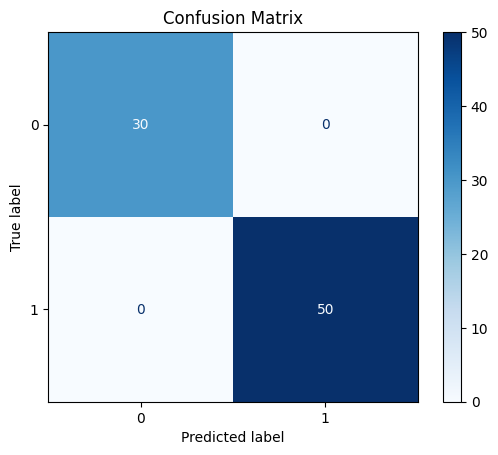

In [ ]:
# now display confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline,x_test,y_test,cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# now print feature importance
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('cat',
                                  Pipeline(steps=[('impute',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc',
                                   'htn', 'dm', 'cad', 'appet', 'pe', 'ane']),
                                 ('num',
                                  Pipeline(steps=[('impute', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu',
                                   'sc', 'sod', 'pot', 'hemo'])]),
 'model': RandomForestClassifier(max_depth=7, random_state=42)}

In [ ]:
model=pipeline.named_steps['model']
feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()
importance=pd.Series(model.feature_importances_,index=feature_names)
print(importance.sort_values(ascending=False).head(16)) 

num__sg             0.138990
num__hemo           0.138533
num__sc             0.090370
cat__htn_yes        0.066642
num__al             0.063780
cat__htn_no         0.054388
num__sod            0.040972
cat__dm_no          0.039526
num__bgr            0.039269
num__bu             0.039075
cat__dm_yes         0.033668
num__bp             0.022937
cat__wc_9200        0.022330
cat__rc_5.2         0.020868
cat__pc_abnormal    0.015263
num__pot            0.012372
dtype: float64


In [ ]:
# # now plot the feature_importances
# importance.head(16).sort_values().plot(kind='barh', figsize=(8,6))
# plt.title("Top 10 Feature Importances for CKD Prediction")
# plt.xlabel("Importance Score")
# plt.ylabel("Clinical Features")
# plt.show()


# it gives wrong result now



In [ ]:
# now understand visualisation
# seaborn & matplotlib for static plots (in notebook)
# plotly.express for interactive charts (perfect for Streamlit)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

In [ ]:
#Bar chart / Pie chart — Target variable distribution (classification)
px.pie(dataset,names='classification')


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

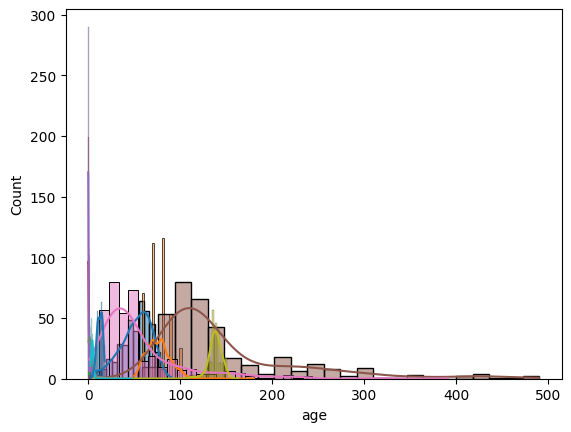

In [ ]:
#a KDE plot as a smooth mountain built over a histogram — showing the “shape” of your data more clearly.
#Check ranges, skewness, and outliers.
# Histograms / KDE plots
for col in num_features:
    sns.histplot(dataset[col], kde=True)

<Axes: xlabel='classification', ylabel='hemo'>

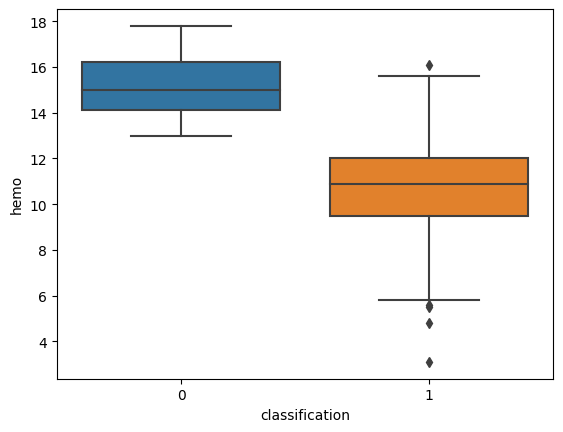

In [ ]:
# Boxplots grouped by CKD status
sns.boxplot(x='classification', y='hemo', data=dataset)

In [ ]:
# #Categorical Feature Exploration

# for col in cat_features:
#     sns.countplot(x=col, hue='classification', data=dataset)


# Stacked Bar (Plotly)
px.histogram(dataset, x='htn', color='classification', barmode='group')

In [ ]:
pd.set_option('display.max_columns',None ) 

dataset.head(1)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,1


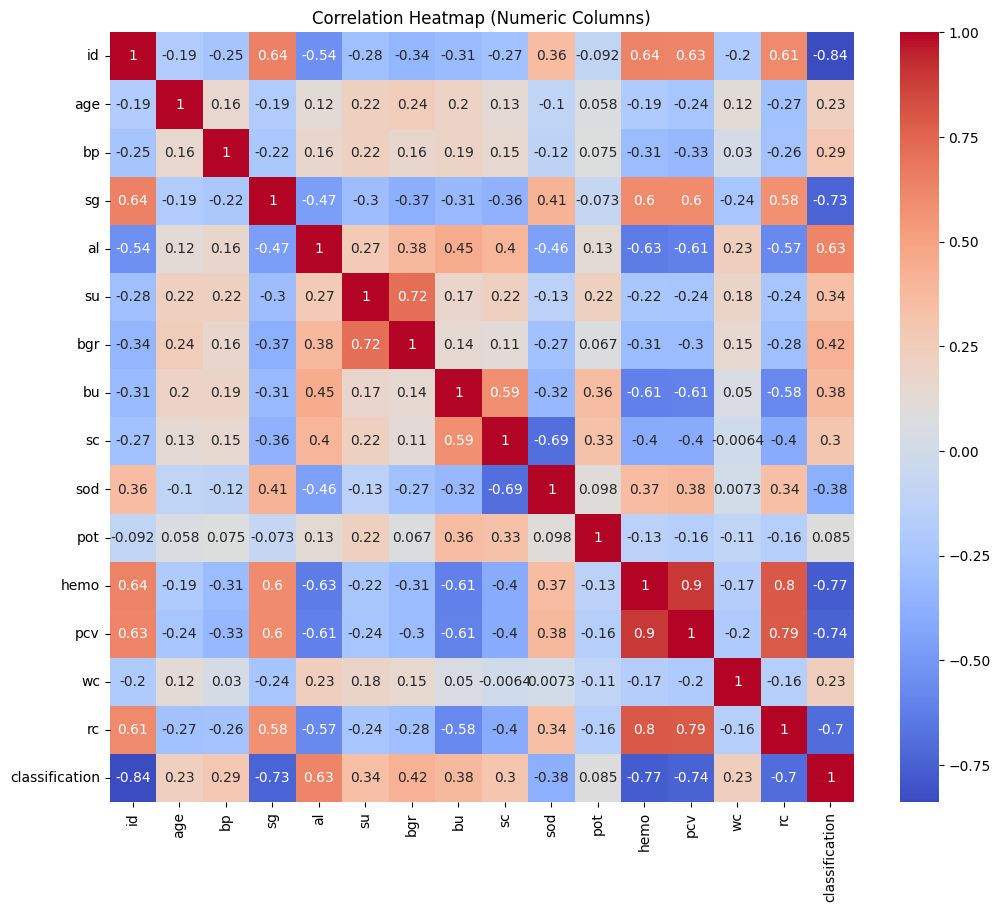

In [ ]:
#Correlations & Relationships
plt.figure(figsize=(12,10))
num_cols = dataset.select_dtypes(include='number').columns
sns.heatmap(dataset[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()

In [ ]:
# Demographics: Age, Gender, BMI

# Blood tests: Hemoglobin (Hb), Blood Urea, Serum Creatinine, Sodium, Potassium

# Urine tests: Albumin, Sugar, Specific Gravity

# Blood Pressure & Clinical Measurements: Systolic BP, Diastolic BP

# Other indicators: Glucose, Diabetes, Hypertension, Appetite, Anemia

# Target: CKD or not (binary classification)


In [ ]:
# Scatter plots (medical insight)
px.scatter(dataset, x='sc', y='hemo', color='classification', title='Serum Creatinine vs Hemoglobin')


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/

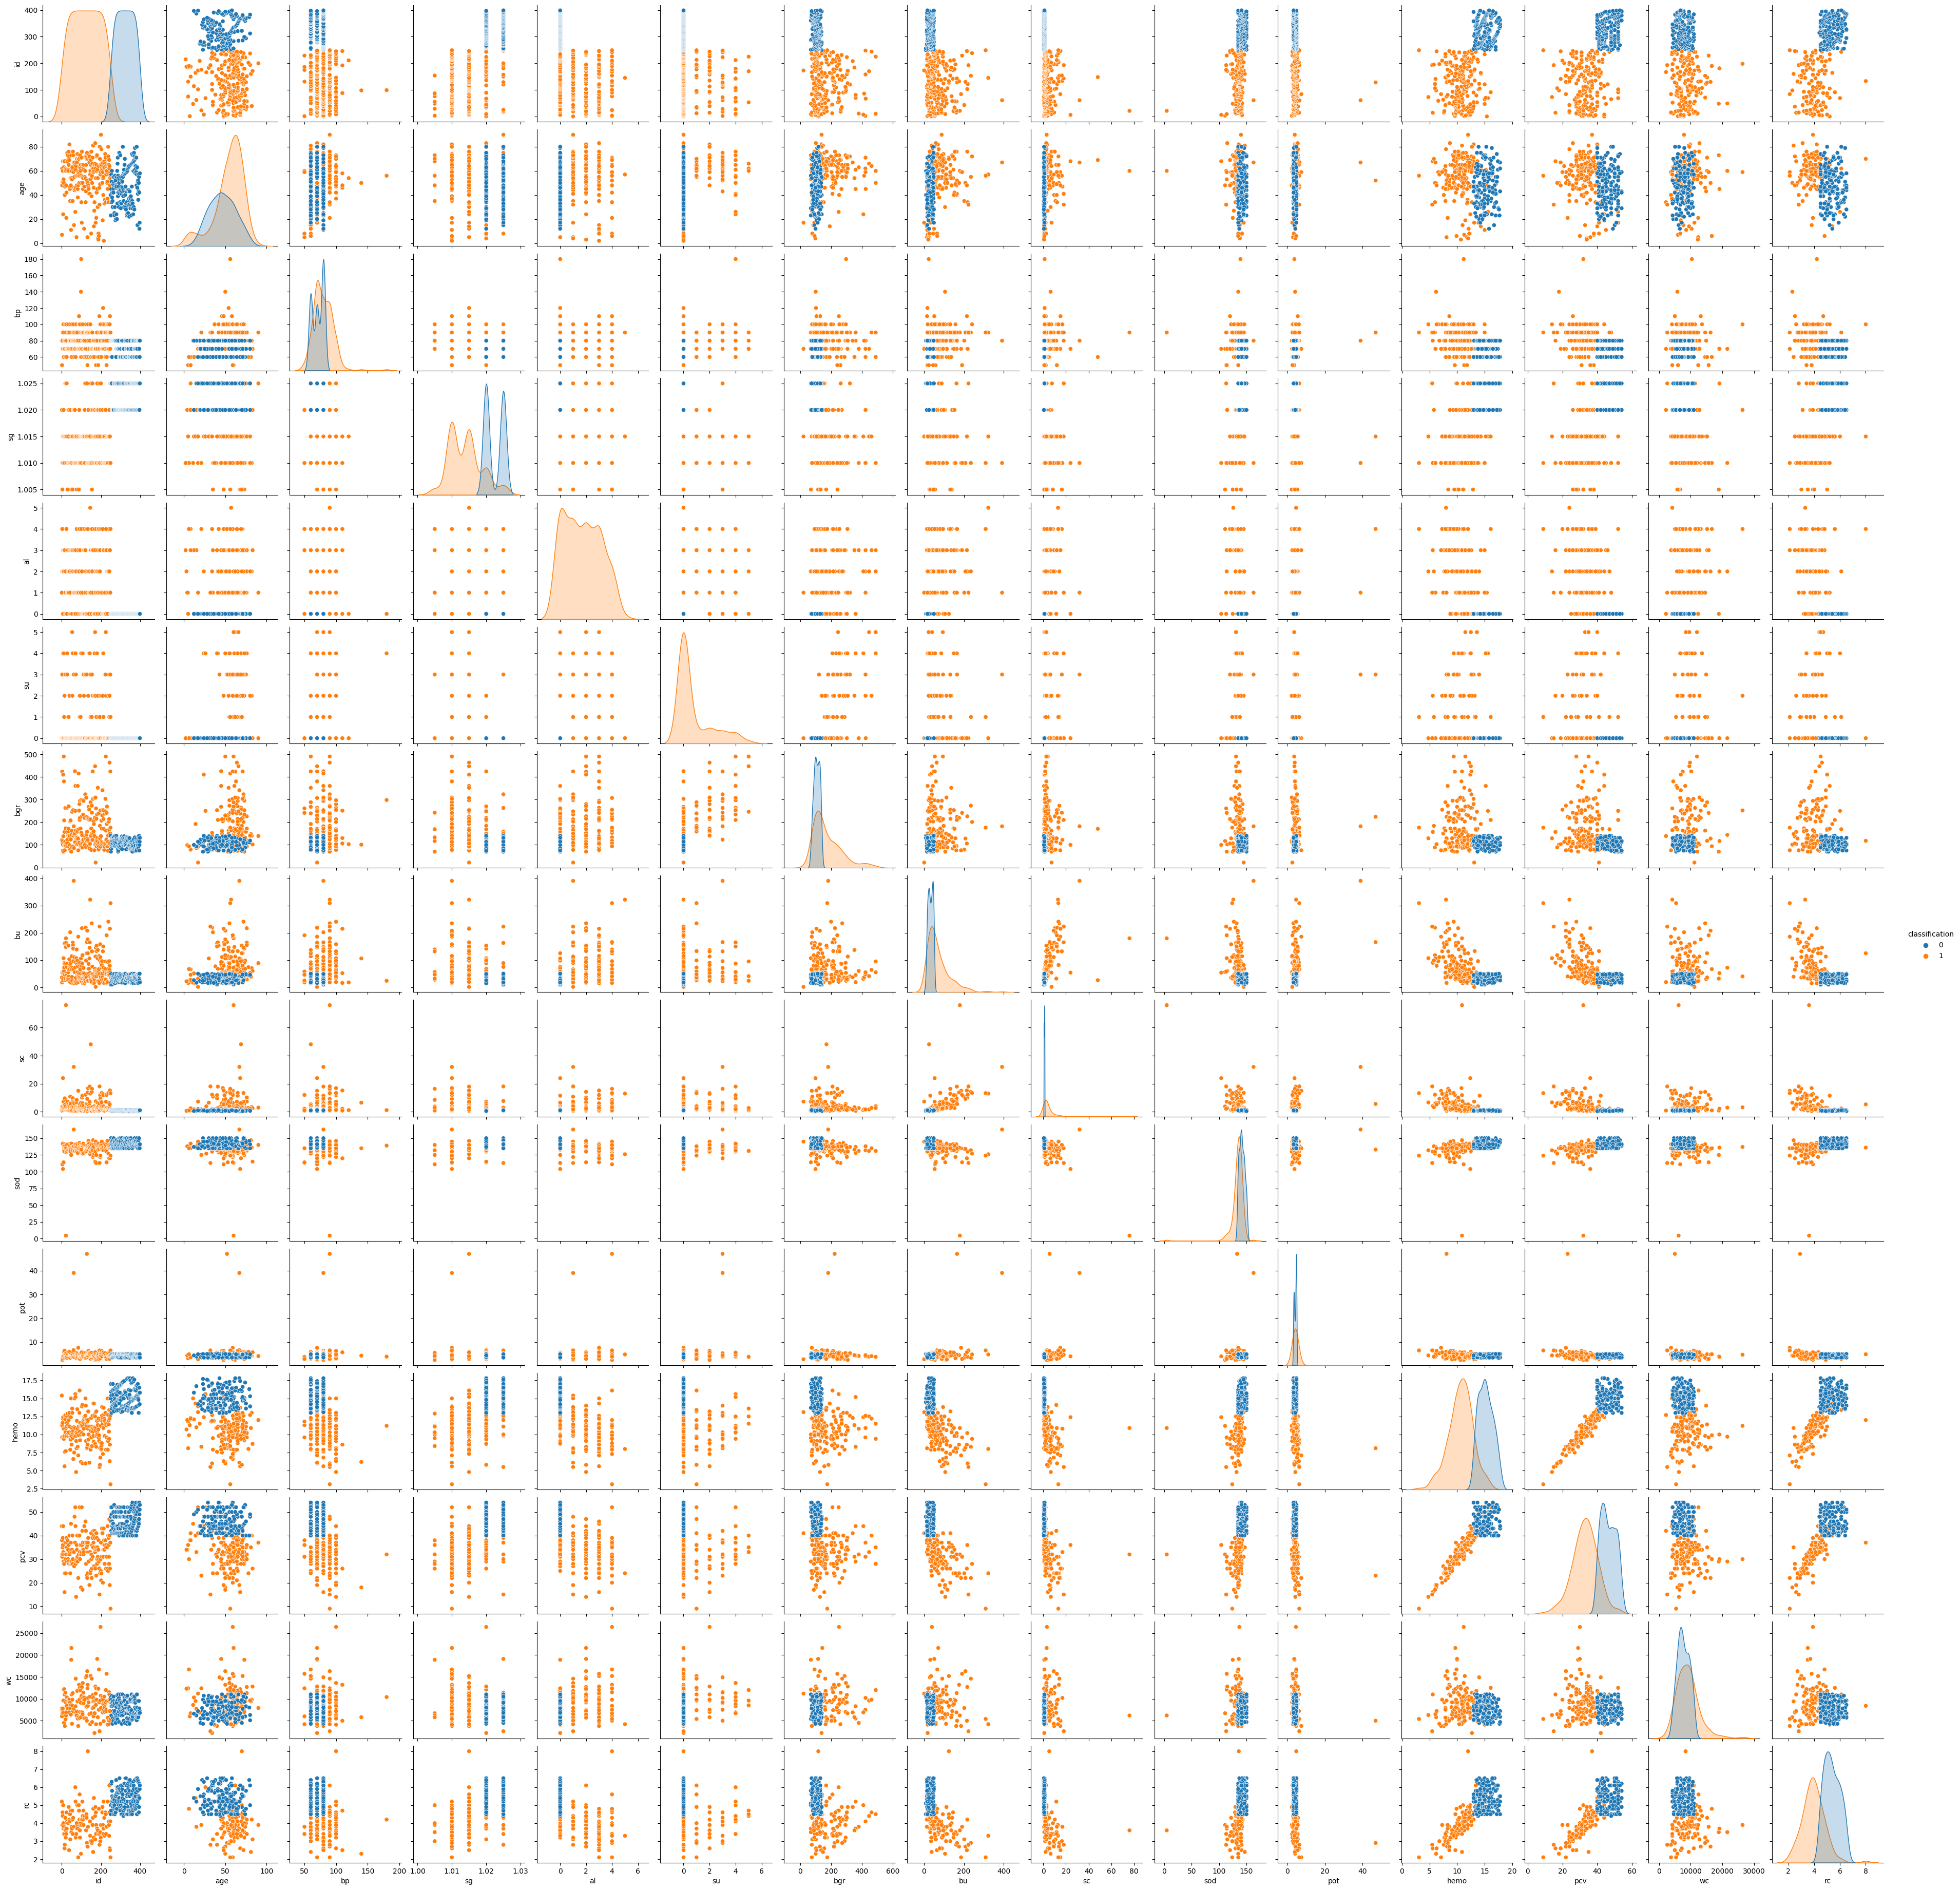

In [ ]:
sns.pairplot(dataset, hue='classification')


| Type                | Plot                   | Purpose           |
| ------------------- | ---------------------- | ----------------- |
| Pie Chart           | Target Distribution    | Dataset balance   |
| Heatmap             | Missing Data           | Data quality      |
| Histogram           | Numeric Features       | Spread, skew      |
| Boxplot             | Feature vs CKD         | Outlier, effect   |
| Countplot           | Categorical Features   | Risk patterns     |
| Correlation Heatmap | Numeric Correlation    | Feature relation  |
| Scatter Plot        | sc vs hemo / bgr vs bu | Clinical insight  |
| Pairplot            | Key Numeric Set        | Overall pattern   |
| Interactive Charts  | Plotly                 | Streamlit visuals |


/tmp/ipykernel_13/724205016.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



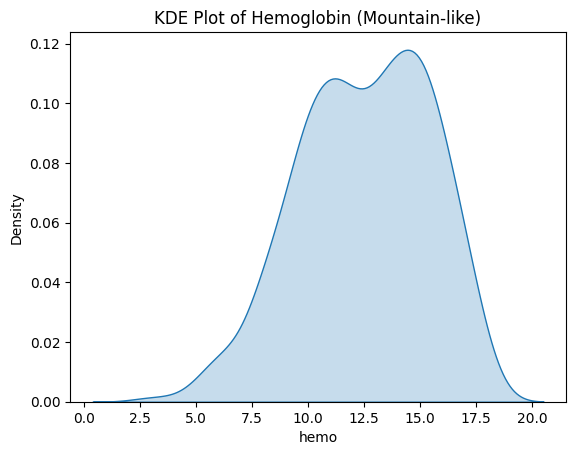

In [ ]:
sns.kdeplot(dataset['hemo'], shade=True)
plt.title("KDE Plot of Hemoglobin (Mountain-like)")
plt.show()


In [ ]:
-- We use 24 + class = 25 ( 11  numeric ,14  nominal)
--      1.Age(numerical)
--   	  	age in years
--  	2.Blood Pressure(numerical)
-- 	       	bp in mm/Hg
--  	3.Specific Gravity(nominal)
-- 	  	sg - (1.005,1.010,1.015,1.020,1.025)
--  	4.Albumin(nominal)
-- 		al - (0,1,2,3,4,5)
--  	5.Sugar(nominal)
-- 		su - (0,1,2,3,4,5)
--  	6.Red Blood Cells(nominal)
-- 		rbc - (normal,abnormal)
--  	7.Pus Cell (nominal)
-- 		pc - (normal,abnormal)
--  	8.Pus Cell clumps(nominal)
-- 		pcc - (present,notpresent)
--  	9.Bacteria(nominal)
-- 		ba  - (present,notpresent)
--  	10.Blood Glucose Random(numerical)		
-- 		bgr in mgs/dl
--  	11.Blood Urea(numerical)	
-- 		bu in mgs/dl
--  	12.Serum Creatinine(numerical)	
-- 		sc in mgs/dl
--  	13.Sodium(numerical)
-- 		sod in mEq/L
--  	14.Potassium(numerical)	
-- 		pot in mEq/L
--  	15.Hemoglobin(numerical)
-- 		hemo in gms
--  	16.Packed  Cell Volume(numerical)
--  	17.White Blood Cell Count(numerical)
-- 		wc in cells/cumm
--  	18.Red Blood Cell Count(numerical)	
-- 		rc in millions/cmm
--  	19.Hypertension(nominal)	
-- 		htn - (yes,no)
--  	20.Diabetes Mellitus(nominal)	
-- 		dm - (yes,no)
--  	21.Coronary Artery Disease(nominal)
-- 		cad - (yes,no)
--  	22.Appetite(nominal)	
-- 		appet - (good,poor)
--  	23.Pedal Edema(nominal)
-- 		pe - (yes,no)	
--  	24.Anemia(nominal)
-- 		ane - (yes,no)